In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# new files
new_files = """/TieBreaker File - 9 Jan 23.xlsx
/TieBreaker File - 10 Jan 23.xlsx
/TieBreaker File - 11 Jan 23.xlsx
/TieBreaker File - 12 Jan 23.xlsx
/TieBreaker File - 13 Jan 23.xlsx
/TieBreaker File - 16 Jan 23.xlsx
/TieBreaker File - 17 Jan 23.xlsx
/TieBreaker File - 18 Jan 23.xlsx
/TieBreaker File - 19 Jan 23.xlsx
/TieBreaker File - 24 Jan 23.xlsx
/TieBreaker File - 25 Jan 23.xlsx
/TieBreaker File - 26 Jan 23.xlsx
/TieBreaker File - 27 _ 29 Jan 23.xlsx""".split('\n')
new_files = ['offshore' + i for i in new_files]

In [3]:
files = [ 
    # v1 files
    'offshore/TieBreaker File - 8 Dec 22.xlsx',
    'offshore/TieBreaker File - 9 Dec 22.xlsx',
    'offshore/TieBreaker File - 12 Dec 22.xlsx',
    'offshore/TieBreaker File - 13 Dec 22.xlsx',
    'offshore/TieBreaker File - 14 Dec 22.xlsx',
    'offshore/TieBreaker File - 15 Dec 22.xlsx',
    'offshore/TieBreaker File - 16 Dec 22.xlsx',
    'offshore/TieBreaker File - 19 Dec 22.xlsx', 
] + new_files

In [4]:
df_original = pd.read_json("../query/top_used_wish_queries_offshore_sample_100000.json", lines=True)

In [5]:
dfs = []
for i in files:
    tmp = pd.read_excel(i)
    tmp['filename'] = i
    dfs.append(tmp)

df_offshore = pd.concat(dfs)[['index', 'filename', 'Sr No', 'query', 'sample_method', 'gmv', 'cnt', 
    'Tiebreaked All SortedByConfidenceHighestFirst taxonomy path Full Paths']].rename( 
        columns={
            'Sr No': 'label_ordering', 
            'Tiebreaked All SortedByConfidenceHighestFirst taxonomy path Full Paths': 'query_classifications'}
    )


df_offshore['label_ordering'] = df_offshore['label_ordering'].astype(int)
df_offshore['index'] = df_offshore['index'].astype(int)
df_offshore['query'] = df_offshore['query'].astype(str)


In [6]:
assert len(df_offshore) == len(set(df_offshore['index']))

In [7]:
df_offshore = df_offshore.merge(df_original[['index', 'query']].rename(columns={'query': 'orig_query'}), on='index', how='inner')
df_offshore.loc[df_offshore['query'] != df_offshore['orig_query'], "query"] = df_offshore.loc[df_offshore['query'] != df_offshore['orig_query'], "orig_query"]
assert len(df_offshore) == len(set(df_offshore['query']))

In [8]:
assert (df_offshore['query'].apply(len) > 0).all()

In [9]:
df = df_offshore

In [10]:
df_oldtest = pd.read_json('processed2/Human_Labelled_Query_Classification_Test.json', lines=True)[['query']].drop_duplicates('query')
df_trainval = pd.concat([ 
    pd.read_json('processed2/Human_Labelled_Query_Classification_Train.json', lines=True)[['query']],
    pd.read_json('processed2/Human_Labelled_Query_Classification_Val.json', lines=True)[['query']]
]).drop_duplicates('query')

In [11]:
len(df), len(df_oldtest), len(df_trainval)

(27487, 4300, 65420)

In [12]:
len(set(df_oldtest['query']).intersection(set(df['query'])))

4300

In [13]:
len(set(df_trainval['query']).intersection(set(df['query'])))

14039

In [14]:
queries_trainval = set(df_trainval['query'])

In [15]:
df = df[df['query'].apply(lambda x: x not in queries_trainval)]

In [16]:
len(df)

13448

In [17]:
df_tax = pd.read_json('../taxonomy/wish_newtax.json', lines=True)
df_tax = df_tax[df_tax.category_path.apply(len) > 0]
errors = []
class Trie:
    def __init__(self):
        self.trie = {}

    def add_text(self, text):
        node = self.trie
        for ind, i in enumerate(text):
            if i not in node:
                node[i] = {}
            node = node[i]
            if ind == len(text) - 1:
                node['<EOS>'] = 1
    
    def extract_from_text(self, text):
        node = self.trie
        res = []
        cur_res = ''
        for ind, i in enumerate(text):
            if i in node:
                node = node[i]
                cur_res += i
            else:
                try:
                    assert '<EOS>' in node
                except:
                    print('ERROR: ', text, res)
                    errors.append(text)
                    return None
                res.append(cur_res)
                cur_res = ''
                node = self.trie
        if len(cur_res) > 0:
            res.append(cur_res)
        
        return res
trie = Trie()
for i in df_tax.category_path.apply(lambda x: x.strip()).tolist():
    trie.add_text(i)
for i in df_tax.category_path.apply(lambda x: x.strip().lower()).tolist():
    trie.add_text(i)
trie.add_text('nan')
trie.add_text('No Categories Match')

In [18]:
manual_correction = {
    "Beauty & Health > Sexual Wellness > Sex Toys,Beauty & Health > Sexual Wellness > SM Products ,nan": \
        "Beauty & Health > Sexual Wellness > Sex Toys,Beauty & Health > Sexual Wellness > SM Products,nan",
    "Apparel Accessories > Girls' Accessories > Girls' Hair Accessories -,Apparel Accessories > Women's Hair Accessories,sports > fitness & body building > yoga > yoga hair bands": \
        "Apparel Accessories > Girls' Accessories > Girls' Hair Accessories,Apparel Accessories > Women's Hair Accessories,sports > fitness & body building > yoga > yoga hair bands",
    "Women's Clothing > Dresses ,women's clothing > weddings & events > wedding dresses,mother & kids > pregnancy & maternity > dresses": \
        "Women's Clothing > Dresses,women's clothing > weddings & events > wedding dresses,mother & kids > pregnancy & maternity > dresses",
    "Women's Clothing > Dresses, Mother & Kids > Girls' Baby Clothing > Dresses,Mother & Kids > Pregnancy & Maternity > Dresses": \
        "Women's Clothing > Dresses,Mother & Kids > Girls' Baby Clothing > Dresses,Mother & Kids > Pregnancy & Maternity > Dresses", 
    "Home & Garden > Arts, Crafts & Sewing > Apparel Sewing & Fabric > Buttons,Retrieving data. Wait a few seconds and try to cut or copy again.,nan": \
        "Home & Garden > Arts, Crafts & Sewing > Apparel Sewing & Fabric > Buttons,nan,nan",
    "Men's Clothing > Tops & Tees > T-Shirts,Watches > Men's Watches > Quartz Watch,Home & Garden > Kitchen,Dining & Bar > Coffeeware > Coffee Cups & Mugs": \
         "Men's Clothing > Tops & Tees > T-Shirts,Watches > Men's Watches > Quartz Watches,Home & Garden > Kitchen,Dining & Bar > Coffeeware > Coffee Cups & Mugs",
    "education & office supplies > writing & correction supplies > stencils,Crafts & Sewing > Scrapbooking & Stamping > Cutting Dies,home & garden > arts, crafts & sewing > apparel sewing & fabric > diy craft supplies": \
        "education & office supplies > writing & correction supplies > stencils,Home & Garden > Arts, Crafts & Sewing > Scrapbooking & Stamping > Cutting Dies,home & garden > arts, crafts & sewing > apparel sewing & fabric > diy craft supplies",
    "Home & Garden > Home Decor > Painting & Calligraphy,Home Improvement > Painting Supplies & Wall Treatments > Wallpapers,Home & Garden > Home Decor > Wall Sticker": \
        "Home & Garden > Home Decor > Painting & Calligraphy,Home Improvement > Painting Supplies & Wall Treatments > Wallpapers,Home & Garden > Home Decor > Wall Stickers",
    "Computer & Office > Office Electronics > Printer,Computer & Office > Office Electronics > All in One Printer,Education & Office Supplies > Paper > Printer Paper": \
        "Computer & Office > Office Electronics > Printers,Computer & Office > Office Electronics > All in One Printer,Education & Office Supplies > Paper > Printer Paper",
    "Home & Garden > Home Textile > Bedding > Pillow Cases, Home & Garden > Home Textile > Bedding > Quilts,Home & Garden > Home Textile > Duvet Cover Sets": \
        "Home & Garden > Home Textile > Bedding > Pillow Cases,Home & Garden > Home Textile > Bedding > Quilts,Home & Garden > Home Textile > Duvet Cover Sets",
    "Accessories > Earrings >\xa0Hoop Earrings,nan,nan": "Jewelry & Accessories > Earrings > Hoop Earrings,nan,nan", 
    "Shoes > Men's Shoes > Men's Boots,Shoes > Women's Shoes > Women's Boots,Children's Shoes > Boys > Boots Mother & Kids > Children's Shoes > Boys > Boots": \
        "Shoes > Men's Shoes > Men's Boots,Shoes > Women's Shoes > Women's Boots,Mother & Kids > Children's Shoes > Boys > Boots",
    "Beauty & Health > Sexual Wellness > SM Products > Bondage Gear,Beauty & Health > Sexual Wellness ,nan": \
        "Beauty & Health > Sexual Wellness > SM Products > Bondage Gear,Beauty & Health > Sexual Wellness,nan",
    "No Category Match": "No Categories Match,nan,nan",
    "car assessories interior,Mother & Kids > Car Seats & Accessories > Head & Body Supports,Mother & Kids > Car Seats & Accessories > Rear Facing Mirrors": \
        "Mother & Kids > Car Seats & Accessories > Head & Body Supports,Mother & Kids > Car Seats & Accessories > Rear Facing Mirrors,nan",
    "No Category Match,nan,nan": "No Categories Match,nan,nan",
    "Education & Office Supplies > Books & Magazines ,nan,nan": "Education & Office Supplies > Books & Magazines,nan,nan",
    "Apparel Accessories > Men's Accessories > Men's Masks,Apparel Accessories > Women's Accessories > Women's Masks  ,nan": \
        "Apparel Accessories > Men's Accessories > Men's Masks,Apparel Accessories > Women's Accessories > Women's Masks,nan",
    "Women's Clothing > Dresses ,Women's Clothing > Sweaters > Dresses,nan": \
        "Women's Clothing > Dresses,Women's Clothing > Sweaters > Dresses,nan",
    "Women's Clothing > Tops > Blouses & Shirts - ,nan,nan": "Women's Clothing > Tops > Blouses & Shirts,nan,nan",
    "Apparel Accessories > Girls' Accessories > Girls' Hair Accessories -,nan,nan": \
        "Apparel Accessories > Girls' Accessories > Girls' Hair Accessories,nan,nan",
    "Women's Clothing > Tops > Blouses & Shirts ,Women's Clothing > Bottoms > Pants,Women's Clothing > Dresses": \
        "Women's Clothing > Tops > Blouses & Shirts,Women's Clothing > Bottoms > Pants,Women's Clothing > Dresses",
    "Women's Clothing > Women's Exotic Apparel > Lingerie sets,nan,nan": \
        "Women's Clothing > Women's Exotic Apparel > Lingerie Sets,nan,nan",
    "Home & Garden > Garden Supplies > Pest Control > Foggers & Sprayers,\xa0,": \
        "Home & Garden > Garden Supplies > Pest Control > Foggers & Sprayers,nan,nan", 
    "Home & Garden > Kitchen,Dining & Bar > Kitchen Knives & Accessories > Blocks & Roll Bags, Home & Garden > Kitchen,Dining & Bar > Kitchen Knives & Accessories,nan": \
        "Home & Garden > Kitchen,Dining & Bar > Kitchen Knives & Accessories > Blocks & Roll Bags,Home & Garden > Kitchen,Dining & Bar > Kitchen Knives & Accessories,nan",
    "Automobiles & motorcycles > Auto replacement parts > exterior parts > chromium styling,Automobiles & Motorcycles > Auto Replacement Parts > Air Conditioning & Heat > Car Air Conditioning,nan": \
        "Automobiles & Motorcycles > Auto Replacement Parts > Exterior Parts > Chromium Styling,Automobiles & Motorcycles > Auto Replacement Parts > Air Conditioning & Heat > Car Air Conditioning,nan",
    "home improvement > bathroom fixtures > bathroom sinks, faucets & accessories,Home Decor > Bathroom >\xa0Faucets,nan": \
        "Home Improvement > Bathroom Fixtures > Bathroom Sinks, Faucets & Accessories > Basin Faucets,nan,nan",
    "Home Improvement > Bathroom Fixtures > Bathroom Sinks, Faucets & Accessories,Home Decor > Bathroom > Faucets,nan": \
        "Home Improvement > Bathroom Fixtures > Bathroom Sinks, Faucets & Accessories > Basin Faucets,nan,nan",
    "Women's Clothing > Dresses - ,Women's Clothing > Weddings & Events > Cocktail Dresses,Women's Clothing > Weddings & Events > Evening Dresses": \
        "Women's Clothing > Dresses,Women's Clothing > Weddings & Events > Cocktail Dresses,Women's Clothing > Weddings & Events > Evening Dresses",
    "Consumer Electronics > Smart Electronics > Wearable Devices > Smart watches,nan,nan": \
        "Consumer Electronics > Smart Electronics > Wearable Devices > Smart Watches,nan,nan",
    "Apparel Accessories > Men's Accessories > Men's Masks,Apparel Accessories > Women's Accessories > Women's Masks - ,Sports > Sports Accessories > Sports Face Masks > Cycling Face Mask": \
        "Apparel Accessories > Men's Accessories > Men's Masks,Apparel Accessories > Women's Accessories > Women's Masks,Sports > Sports Accessories > Sports Face Masks > Cycling Face Mask", 
    "No match category,nan,nan": "No Categories Match,nan,nan", 
    "Automotive > Parts & Accessories >\xa0Car Accessories,nan,nan": "Automobiles & Motorcycles > Interior Accessories,Automobiles & Motorcycles > Exterior Accessories,nan",
    "Sports > Fishing > Fishing Tools,sports > Fishing > Fishing Accessories,nan": \
        "Sports > Fishing > Fishing Tools,Sports > Fishing > Fishing Accessories,nan",
    "Hobbies > Outdoor & Camping Accessories >\xa0Sports Equipment,nan,nan": \
        "Sports,nan,nan",
    "Toys & hobbies > diecast & toy vehicles,toys & hobbies > play vehicles & models,toys & hobbies > play vehicles & models > railed, motor cars & bicycles": \
        "Toys & Hobbies > Diecast & Toy Vehicles,Toys & Hobbies > Play Vehicles & Models,Toys & Hobbies > Play Vehicles & Models > Railed, Motor Cars & Bicycles",
    "Hobbies > Outdoor & Camping Accessories > Sports Equipment,nan,nan": "Sports,nan,nan", 
    "Consumer electronics > power source > batteries,nan,nan": "Consumer Electronics > Power Source > Batteries,nan,nan",
    "Beauty & Health > Oral Hygiene > Teeth Whitening,Beauty & Health > oral hygiene > dental supplies > dental basic instrument,Beauty & Health > oral hygiene > dental supplies": \
        "Beauty & Health > Oral Hygiene > Teeth Whitening,Beauty & Health > Oral Hygiene > Dental Supplies > Dental Basic Instrument,Beauty & Health > Oral Hygiene > Dental Supplies",
    "Home & Garden > pet products > pet health care & hygiene > supplements & vitamins,Beauty & Health > Health Care > Personal Health Care,nan": \
        "Home & Garden > Pet Products > Pet Health Care & Hygiene > Supplements & Vitamins,Beauty & Health > Health Care > Personal Health Care,nan",
    "Jewelry & accessories > necklaces & pendants,Jewelry & Accessories > Customized Jewelry > Customized Necklaces,nan": \
        "Jewelry & Accessories > Necklaces & Pendants,Jewelry & Accessories > Customized Jewelry > Customized Necklaces,nan",
    "Beauty & Health > Skin Care Tools > Jade Roller,Beauty & health > skin care tools > facial care tool,Beauty & Health > Skin Care Tools > Face Lift Devices": \
        "Beauty & Health > Skin Care Tools > Jade Roller,Beauty & Health > Skin Care Tools > Facial Care Tool,Beauty & Health > Skin Care Tools > Face Lift Devices", 
    "Women's Clothing > Tops > Tees,Women's Clothing > Tops > Blouses & Shirts ,nan": \
        "Women's Clothing > Tops > Tees,Women's Clothing > Tops > Blouses & Shirts,nan",
    "Beauty & Health > Skin Care > Face > Cleansers,Beauty & Health > Makeup > Makeup Remover,Beauty & Health > Skin Care > Face > Clean": \
        "Beauty & Health > Skin Care > Face > Cleansers,Beauty & Health > Makeup > Makeup Remover,nan",
    "Shoes > women's shoes > women's flats,Shoes > Women's Shoes > Loafers,Shoes > Women's Shoes > Women's Pumps": \
        "Shoes > Women's Shoes > Women's Flats,Shoes > Women's Shoes > Loafers,Shoes > Women's Shoes > Women's Pumps",
    "Apparel Accessories > Women's Hair Accessories,Apparel Accessories > Girls' Accessories > Girls' Hair Accessories -,Mother & Kids > Girls' Baby Clothing > Accessories > Hair Accessories": \
        "Apparel Accessories > Women's Hair Accessories,Apparel Accessories > Girls' Accessories > Girls' Hair Accessories,Mother & Kids > Girls' Baby Clothing > Accessories > Hair Accessories",
    "Beauty & Health > Shaving & Hair Removal > Razor Blade,Beauty & Health > Shaving & Hair Removal > Razor ,nan": \
        "Beauty & Health > Shaving & Hair Removal > Razor Blade,Beauty & Health > Shaving & Hair Removal > Razor,nan",
    "Women's Clothing > Tops > Tees,Women's Clothing > Tops > Blouses & Shirts - ,Women's Clothing > Tops > Tank Tops": \
        "Women's Clothing > Tops > Tees,Women's Clothing > Tops > Blouses & Shirts,Women's Clothing > Tops > Tank Tops",
    "Home & garden > bathroom products > bath mats,Home & Garden > Home Textile > Carpets & Rugs > Mats,nan": \
        "Home & Garden > Bathroom Products > Bath Mats,Home & Garden > Home Textile > Carpets & Rugs > Mats,nan",
    "Tools > garden tools > garden power tools > chainsaws,Tools > Power Tools > Electric Saws,Tools > Power Tools": \
        "Tools > Garden Tools > Garden Power Tools > Chainsaws,Tools > Power Tools > Electric Saws,Tools > Power Tools",
    "Home improvement > home appliances > personal care appliances > electric hair brushes,Beauty & Health > Hair Care & Styling > Styling Tools > Combs,Beauty & Health > Hair Care & Styling > Styling Tools > Styling Accessories": \
        "Home Improvement > Home Appliances > Personal Care Appliances > Electric Hair Brushes,Beauty & Health > Hair Care & Styling > Styling Tools > Combs,Beauty & Health > Hair Care & Styling > Styling Tools > Styling Accessories",
    "Men's Clothing > Men's Exotic Apparel > Teddies & Bodysuits,Men's Clothing > Men's Exotic Apparel > Thongs,nan": \
        "Men's Clothing > Men's Exotic Apparel > Teddies & Bodysuits,Men's Clothing > Men's Exotic Apparel > G-Strings & Thongs,nan",
    "Novelty & Special Use > Costumes & Accessories > Women's Costumes > Sexy Costumes,Women's clothing > women's exotic apparel > lingerie sets,nan": \
        "Novelty & Special Use > Costumes & Accessories > Women's Costumes > Sexy Costumes,Women's Clothing > Women's Exotic Apparel > Lingerie Sets,nan",
    "Consumer Electronics > Camera & Photo > Photo Studio > Follow focus,Men's Clothing > Tops & Tees > T-Shirts,Home & Garden > Home Decor > Painting & Calligraphy": \
        "Consumer Electronics > Camera & Photo > Photo Studio > Follow Focus,Men's Clothing > Tops & Tees > T-Shirts,Home & Garden > Home Decor > Painting & Calligraphy",
    "Mother & Kids > Boys' Baby Clothing > Accessories > Hats & Caps,Mother & Kids > Girls' Baby Clothing > Accessories > Hats & Caps ,nan": \
        "Mother & Kids > Boys' Baby Clothing > Accessories > Hats & Caps,Mother & Kids > Girls' Baby Clothing > Accessories > Hats & Caps,nan",
    "Apparel Accessories > Boys' Accessories > Boys' Hats,Apparel Accessories > Girls' Accessories > Girls' Hats,nan": \
        "Apparel Accessories > Boys' Accessories > Boys' Hats,Apparel Accessories > Girls' Accessories > Girls' Hats,nan",
    "Apparel Accessories > Women's Hats > Women's Cowboy Hats,Apparel Accessories > Girls' Accessories > Girls' Hats,nan": \
        "Apparel Accessories > Women's Hats > Women's Cowboy Hats,Apparel Accessories > Girls' Accessories > Girls' Hats,nan",
    "Sports > Camping & Hiking > Tents & Shelters > Tents,Sports > camping & hiking > tents & shelters > sun shelter,nan": \
        "Sports > Camping & Hiking > Tents & Shelters > Tents,Sports > Camping & Hiking > Tents & Shelters > Sun Shelter,nan",
    "Women's clothing > underwear & sleepwear > women's sleepwear > pajama sets,Novelty & Special Use > Costumes & Accessories > Women's Costumes,Novelty & Special Use > Costumes & Accessories > Men's Costumes": \
        "Women's Clothing > Underwear & Sleepwear > Women's Sleepwear > Pajama Sets,Novelty & Special Use > Costumes & Accessories > Women's Costumes,Novelty & Special Use > Costumes & Accessories > Men's Costumes",
    "Apparel Accessories > Girls' Accessories > Girls' Scarves,Apparel Accessories > Men's Scarves,Apparel Accessories > Women's Scarves -": \
        "Apparel Accessories > Girls' Accessories > Girls' Scarves,Apparel Accessories > Men's Scarves,Apparel Accessories > Women's Scarves",
    "Cellphones & Telecommunications > iphones,nan,nan": "Cellphones & Telecommunications > iPhones,nan,nan", 
    "Apparel Accessories > Garment Fabrics & Accessories > Cotton Fabrics - ,nan,nan": \
        "Apparel Accessories > Garment Fabrics & Accessories > Cotton Fabrics,nan,nan", 
    "Men's Clothing > Hoodies & Sweatshirts,Women's Clothing > Tops > Tees,Women's Clothing > Dresses -": \
        "Men's Clothing > Hoodies & Sweatshirts,Women's Clothing > Tops > Tees,Women's Clothing > Dresses",
    "Women's Clothing > Dresses ,Women's Clothing > Weddings & Events > Cocktail Dresses,Women's Clothing > Weddings & Events > Evening Dresses": \
        "Women's Clothing > Dresses,Women's Clothing > Weddings & Events > Cocktail Dresses,Women's Clothing > Weddings & Events > Evening Dresses",
    "Apparel Accessories > Women's Hair Accessories,Apparel Accessories > Girls' Accessories > Girls' Hair Accessories -,nan": \
        "Apparel Accessories > Women's Hair Accessories,Apparel Accessories > Girls' Accessories > Girls' Hair Accessories,nan", 
    "Toys & Hobbies > Remote Control Toys > RC Trucks,Toys & Hobbies > Remote Control Toys ,nan": \
        "Toys & Hobbies > Remote Control Toys > RC Trucks,Toys & Hobbies > Remote Control Toys,nan",
    "Women's Clothing > Dresses - ,nan,nan": "Women's Clothing > Dresses,nan,nan",
    "Women's Clothing > Dresses - ,Women's Clothing > Tops > Tank Tops,Women's Clothing > Bottoms > Skirts": \
        "Women's Clothing > Dresses,Women's Clothing > Tops > Tank Tops,Women's Clothing > Bottoms > Skirts", 
    "Apparel Accessories > Girls' Accessories > Girls' Hair Accessories -,Beauty & Health > Hair Care & Styling,Beauty & Health > Hair Care & Styling": \
        "Apparel Accessories > Girls' Accessories > Girls' Hair Accessories,Beauty & Health > Hair Care & Styling,Beauty & Health > Hair Care & Styling",
    "Beauty & health > sexual wellness > sex toys,Beauty & Health > Sexual Wellness,nan": \
        "Beauty & Health > Sexual Wellness > Sex Toys,Beauty & Health > Sexual Wellness,nan", 
    "Education & Office Supplies > Writing & Correction Supplies > Gel Pens,Education & office supplies > writing & correction supplies > marker pens,nan": \
        "Education & Office Supplies > Writing & Correction Supplies > Gel Pens,Education & Office Supplies > Writing & Correction Supplies > Marker Pens,nan",
    "Toys & Hobbies > Action & Toy Figures > Action Figures,Toys & Hobbies > Stuffed Animals & Plush Toys > Movies & Tv,nan": \
        "Toys & Hobbies > Action & Toy Figures > Action Figures,Toys & Hobbies > Stuffed Animals & Plush Toys > Movies & TV,nan", 
    "Men's clothing > pants > casual pants,Women's Clothing > Bottoms > Pants,Men's clothing > pants": \
        "Men's Clothing > Pants > Casual Pants,Women's Clothing > Bottoms > Pants,Men's Clothing > Pants", 
    "women's clothing > women's exotic apparel > lingerie sets		,nan,nan": \
        "Women's Clothing > Women's Exotic Apparel > Lingerie Sets,nan,nan", 
    "Men's clothing > jackets & coats > jackets,Men's Clothing > Jackets & Coats > Down Jackets,Men's Clothing > Jackets & Coats > Faux Leather Coats": \
        "Men's Clothing > Jackets & Coats > Jackets,Men's Clothing > Jackets & Coats > Down Jackets,Men's Clothing > Jackets & Coats > Faux Leather Coats", 
    "Security & protection > video surveillance > surveillance cameras,Consumer Electronics > Camera & Photo > Camcorders > Mini Camcorders,nan": \
        "Security & Protection > Video Surveillance > Surveillance Cameras,Consumer Electronics > Camera & Photo > Camcorders > Mini Camcorders,nan",
    "Women's Clothing > Dresses - ,Women's Clothing > Weddings & Events > Evening Dresses,Women's Clothing > Weddings & Events > Cocktail Dresses": \
        "Women's Clothing > Dresses,Women's Clothing > Weddings & Events > Evening Dresses,Women's Clothing > Weddings & Events > Cocktail Dresses",
    "Apparel Accessories > Men's Scarves,Apparel Accessories > Women's Scarves - ,nan": \
        "Apparel Accessories > Men's Scarves,Apparel Accessories > Women's Scarves,nan",
    "Women's Clothing > Tops,Women's Clothing > Tops > Blouses & Shirts - ,Women's Clothing > Tops > Tees": \
        "Women's Clothing > Tops,Women's Clothing > Tops > Blouses & Shirts,Women's Clothing > Tops > Tees", 
    "Toys & Hobbies > Stuffed Animals & Plush Toys > Stuffed & Plush Animals,Toys & hobbies > stuffed animals & plush toys > plush pillows,nan": \
        "Toys & Hobbies > Stuffed Animals & Plush Toys > Stuffed & Plush Animals,Toys & Hobbies > Stuffed Animals & Plush Toys > Plush Pillows,nan", 
    "Watches > men's watches,Watches > women's watches,Watches > Men's Watches > Mechanical Watches": \
        "Watches > Men's Watches,Watches > Women's Watches,Watches > Men's Watches > Mechanical Watches", 
    "Home & Garden > arts, crafts & sewing > soap making > soap molds,nan,nan": \
        "Home & Garden > Arts, Crafts & Sewing > Soap Making > Soap Molds,nan,nan", 
    "Toys & Hobbies > Pools & Water Fun > Pool Rafts & Inflatable Ride-ons,Sports > Swimming > Swimming Accessories > Swimming Rings,Sports > Water Sports > Water  Products > Life Raft": \
        "Toys & Hobbies > Pools & Water Fun > Pool Rafts & Inflatable Ride-ons,Sports > Swimming > Swimming Accessories > Swimming Rings,Sports > Water Sports > Water Safety Products > Life Raft",
    "Apparel Accessories > Women's Scarves - ,Apparel Accessories > Girls' Accessories > Girls' Scarves,nan": \
        "Apparel Accessories > Women's Scarves,Apparel Accessories > Girls' Accessories > Girls' Scarves,nan",
    "Home & Garden > kitchen,dining & bar > kitchen tools & gadgets > kitchen timers,nan,nan": \
        "Home & Garden > Kitchen,Dining & Bar > Kitchen Tools & Gadgets > Kitchen Timers,nan,nan",
    "Home & Garden > Garden Supplies > Garden Buildings > Fencing, Trellis & Gate,Mother & Kids > Safety Equipment > Gates & Doorways,nan": \
        "Home & Garden > Garden Supplies > Garden Buildings > Fencing, Trellis & Gates,Mother & Kids > Safety Equipment > Gates & Doorways,nan",
    "Mother & kids > girls' clothing > dresses,Mother & kids > girls' clothing > clothing sets,Mother & Kids > Girls' Baby Clothing > Dresses": \
        "Mother & Kids > Girls' Clothing > Dresses,Mother & Kids > Girls' Clothing > Clothing Sets,Mother & Kids > Girls' Baby Clothing > Dresses",
    "Consumer Electronics > video Games > video Games Consoles,Consumer Electronics > Video Games > Cases,nan": \
        "Consumer Electronics > Video Games > Video Game Consoles,Consumer Electronics > Video Games > Cases,nan",
    "Mother & Kids > Feeding > Nipple & Accessories  Nipple & Accessories > Pacifier,Mother & Kids > Feeding > Nipple & Accessories > Pacifier,Mother & Kids > Baby Care > Baby Teethers": \
        "Mother & Kids > Feeding > Nipple & Accessories > Pacifier,Mother & Kids > Baby Care > Baby Teethers,nan",
    "Sports > hunting > hunting optics > monocular/binoculars,Tools > measurement & analysis instruments > optical instruments > telescope & binoculars,nan": \
        "Sports > Hunting > Hunting Optics > Monocular/Binoculars,Tools > Measurement & Analysis Instruments > Optical Instruments > Telescope & Binoculars,nan"
}

In [19]:
df['query_classifications'] = df.query_classifications.apply(lambda x: x.strip().replace('\n', '').replace('| ',',').replace('|',',')).apply(
    lambda x: manual_correction[x] if x in manual_correction else x)

/tmp/ipykernel_29559/3570168300.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['query_classifications'] = df.query_classifications.apply(lambda x: x.strip().replace('\n', '').replace('| ',',').replace('|',',')).apply(


In [20]:
df['query_classification_lists'] = df.query_classifications.apply(trie.extract_from_text)

ERROR:  Apparel Accessories > Girls' Accessories > Girls' Hats,Apparel Accessories > Women's Hats,Apparel Accessories > Girls' Accessories > Girls' Hats, Scarves & Gloves Sets []
ERROR:  Apparel Accessories > Men's Hats,Apparel Accessories > Girls' Accessories > Girls' Hats,Apparel Accessories > Men's Hats > Men's Sun Hats ["Apparel Accessories > Men's Hats"]
ERROR:  Apparel Accessories > Boys' Accessories > Boys' Hats,Apparel Accessories > Girls' Accessories > Girls' Hats,Mother & Kids > Boys' Baby Clothing > Accessories > Hats & Caps []


/tmp/ipykernel_29559/2681698061.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['query_classification_lists'] = df.query_classifications.apply(trie.extract_from_text)


In [21]:
trie.extract_from_text('Sports > Hunting > Hunting Optics')

['Sports > Hunting > Hunting Optics']

In [22]:
recs = []
for i in df.to_dict('records'):
    if i['query_classifications'] == "Apparel Accessories > Girls' Accessories > Girls' Hats,Apparel Accessories > Women's Hats,Apparel Accessories > Girls' Accessories > Girls' Hats, Scarves & Gloves Sets":
        i['query_classification_lists'] = [
            "Apparel Accessories > Girls' Accessories > Girls' Hats",
            "Apparel Accessories > Women's Hats",
            "Apparel Accessories > Girls' Accessories > Girls' Hats, Scarves & Gloves Sets"
        ]
    if i['query_classifications'] == "Apparel Accessories > Men's Hats,Apparel Accessories > Girls' Accessories > Girls' Hats,Apparel Accessories > Men's Hats > Men's Sun Hats":
        i['query_classification_lists'] = [
            "Apparel Accessories > Men's Hats", 
            "Apparel Accessories > Girls' Accessories > Girls' Hats",
            "Apparel Accessories > Men's Hats > Men's Sun Hats"
        ]
    if i['query_classifications'] == "Apparel Accessories > Boys' Accessories > Boys' Hats,Apparel Accessories > Girls' Accessories > Girls' Hats,Mother & Kids > Boys' Baby Clothing > Accessories > Hats & Caps":
        i['query_classification_lists'] = [
            "Apparel Accessories > Boys' Accessories > Boys' Hats", 
            "Apparel Accessories > Girls' Accessories > Girls' Hats", 
            "Mother & Kids > Boys' Baby Clothing > Accessories > Hats & Caps"
        ]
    recs.append(i)
df = pd.DataFrame(recs)

In [23]:
path2id = {}
for i in df_tax.to_dict('records'):
    path2id[i['category_path'].lower().strip()] = i['id']
    path2id[i['category_path'].strip()] = i['id']
id2path = {}
for i in df_tax.to_dict('records'):
    id2path[i['id']] = i['category_path']

In [24]:
path2id['nan'] = -1
path2id['No Categories Match'] = -1

In [25]:
df['query_classification_ids'] = df['query_classification_lists'].apply(lambda x: [path2id[i] for i in x])

In [26]:
def convert_id_to_path(li):
    if set(li) == set([-1]):
        return []
    else:
        res = [] 
        for i in li:
            if int(i) in id2path:
                res.append(id2path[int(i)])
        return res

In [27]:
df['query_classification_lists'] = df['query_classification_ids'].apply(convert_id_to_path).apply(tuple)

<AxesSubplot: ylabel='Frequency'>

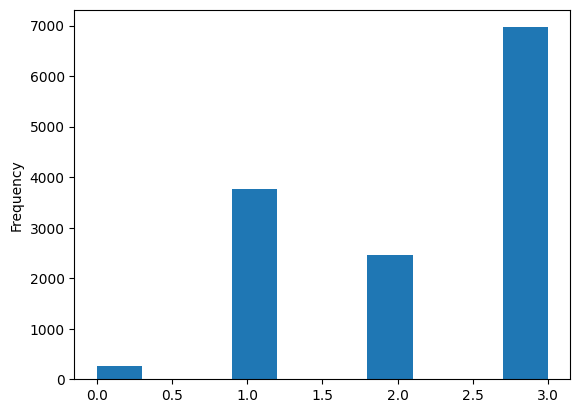

In [28]:
df.query_classification_lists.apply(len).plot.hist()

<AxesSubplot: ylabel='sample_method'>

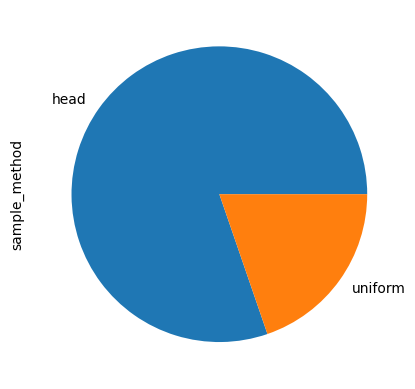

In [29]:
df.sample_method.value_counts().plot.pie()

<AxesSubplot: ylabel='Frequency'>

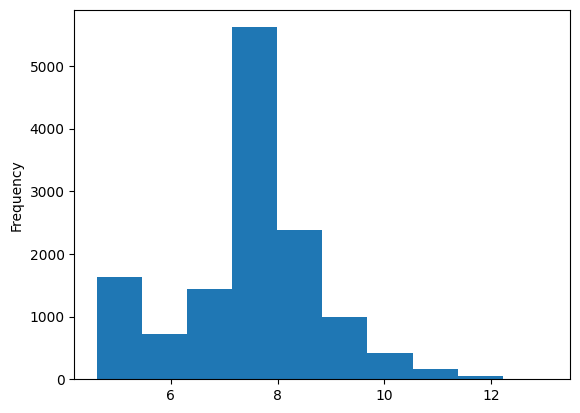

In [30]:
df.cnt.apply(np.log).plot.hist()

<AxesSubplot: ylabel='Frequency'>

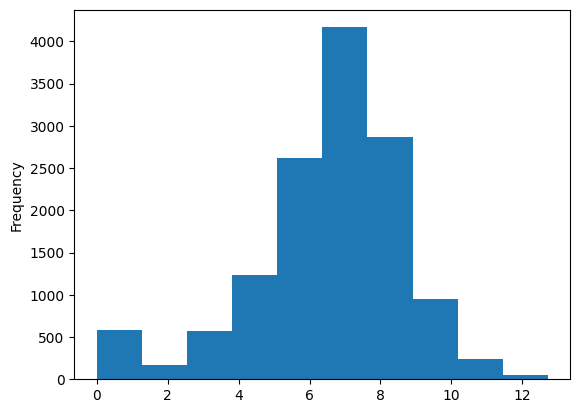

In [31]:
df.gmv.apply(lambda x: np.log(x + 1)).plot.hist()

<AxesSubplot: ylabel='query_classification_lists'>

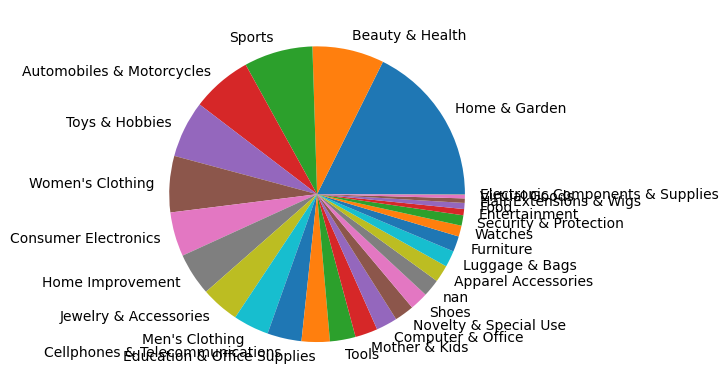

In [32]:
plt.axis('off')
df['query_classification_lists'].apply(lambda x: x[0].split(" > ")[0] if len(x) > 0 else 'nan').value_counts().plot.pie()

In [33]:
len(df)

13448

In [34]:
df.to_excel('processed/tmp_Offshore_Labelled_Query_Classification_Test.xlsx', index=False)

In [36]:
# after google sheet translate
tmp = pd.read_excel('processed/tmp_Offshore_Labelled_Query_Classification_Test.xlsx')

In [37]:
df['lang'] = tmp['lang'].tolist()

<AxesSubplot: ylabel='lang'>

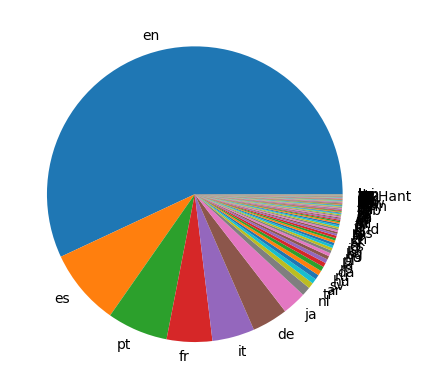

In [38]:
plt.axis('off')
df['lang'].value_counts().plot.pie()

In [40]:
assert len(set(df_trainval['query']).intersection(set(df['query']))) == 0

In [41]:
df.to_json('processed/Offshore_Labelled_Query_Classification_Test_V2.json', orient='records', 
    lines=True)